In [1]:
cd PycharmProjects/motoki_ul/review_analysis

[Errno 2] No such file or directory: 'PycharmProjects/motoki_ul/review_analysis'
/Users/motoki/PycharmProjects/motoki_ul/review_analysis


In [131]:
##Clean raw data & prepare for analytics

import pandas as pd

input_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/input_dir/amazon"
df = pd.read_csv(f"{input_dir}/20210804_review_sum.csv")
df.fillna("。")

category = "RooibosTea"
flavor = "EarlGray"
decaf = "DeCaf"

df.rename(columns={"product": "product_name"}, inplace=True)

#Found NaN in title columns so replaced
df["combined_title"] = df["title"].fillna("。").str.cat(" " + df["comment"])
df_new_raw = pd.concat([df["ASIN"], df["product_name"], df["brand"], df["combined_title"], df["Category"], df["Flavor"], df["DeCaf"]], axis=1)
df_new = df_new_raw.fillna(0)
df_new = df_new[df_new["Category"].str.contains(category, na=False)]
#df_new = df_new[df_new["Flavor"].str.contains(flavor)]
df_new = df_new[df_new["DeCaf"].str.contains(decaf, na=False)]
#df_new = df_new[df_new["product_name"].str.contains('カフェイン')]
#df_new = df_new[~df_new["sub-category"].str.contains(sub_category_excl)]
#print(df_new)
df_new.info()

#Combine comments on each product (for Doc2Vec)
#df_new_combined = df_new[~df_new.duplicated(subset='ASIN')]
df_new_combined = df_new.groupby(["product_name", "ASIN", "brand"])["combined_title"].sum().reset_index()
df_new_combined.product

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2586 entries, 127 to 19309
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ASIN            2586 non-null   object
 1   product_name    2586 non-null   object
 2   brand           2586 non-null   object
 3   combined_title  2586 non-null   object
 4   Category        2586 non-null   object
 5   Flavor          2586 non-null   object
 6   DeCaf           2586 non-null   object
dtypes: object(7)
memory usage: 161.6+ KB


<bound method DataFrame.prod of                                          product_name        ASIN  \
0   AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末  B08X4X6DS3   
1   【Amazon.co.jp限定】 リプトン アップルルイボス 75杯分 デカフェ・ノンカフェ...  B086VVQQLL   
2   【Amazon.co.jp限定】 リプトン バニラルイボス 75杯分 デカフェ・ノンカフェイ...  B086VT9YBL   
3   【まとめ買い】ティーライフ ルイボスティー 101個×2袋セット (ノンカフェイン ルイボス...  B07LGPDG8T   
4      オーガニック ルイボスティー 特級エクストラファイン 有機JAS ティーバッグ 3g×50包  B01N4DUIMX   
5   ティーライフ ルイボスティー 2.0g×101個 (ノンカフェイン ルイボス茶 水出し お茶...  B005OUQXW0   
6     トワイニング アール グレイ ルイボス 20P ×2箱 デカフェ・ノンカフェイン ティーバッグ  B08DTTPFGZ   
7        リプトン ストロベリールイボス ティーバッグ 15袋入 ×6袋 デカフェ・ノンカフェイン  B08G4T1QXQ   
8                    伊藤園 ヘルシールイボスティー ティーバッグ 2.0g×100袋  B07JGN484D   
9        伊藤園 ヘルシールイボスティー ティーバッグ デカフェ・ノンカフェイン 3.0g×60袋  B07P5XXCKP   
10         生姜 ルイボスティー 菊芋 巡りChaCha ノンカフェイン ブレンドティー 40包  B07V3GVGZ6   

           brand                                     combined_title  
0    AGF(エージーエフ)  味の好みは人それぞれ前提 THERMOSの350mlのステンレスボトルにお湯で作ってみました...  

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/motoki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


        word  count
59        飲み   1201
184       飲ん    959
81      美味しい    888
87   ルイボスティー    823
221      やすい    644
19        思い    596
91        購入    563
13        良い    503
62        入れ    494
111       いい    432
46        香り    430
299       いる    423
166      パック    388
34       ティー    388
285       お茶    385
501    カフェイン    377
99        入っ    327
228       なく    319
102       あり    315
107       なっ    306
18        飲む    289
563       出し    269
152     美味しく    266
188       商品    259
115      やすく    258
138       なり    249
230        量    247
676     おいしい    246
180     リピート    241
6         お湯    240


<Figure size 2160x1440 with 0 Axes>

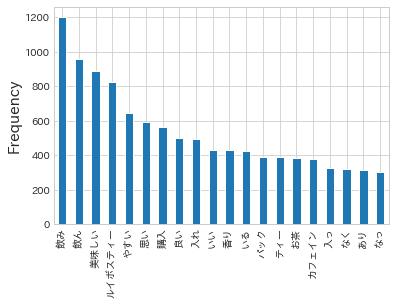

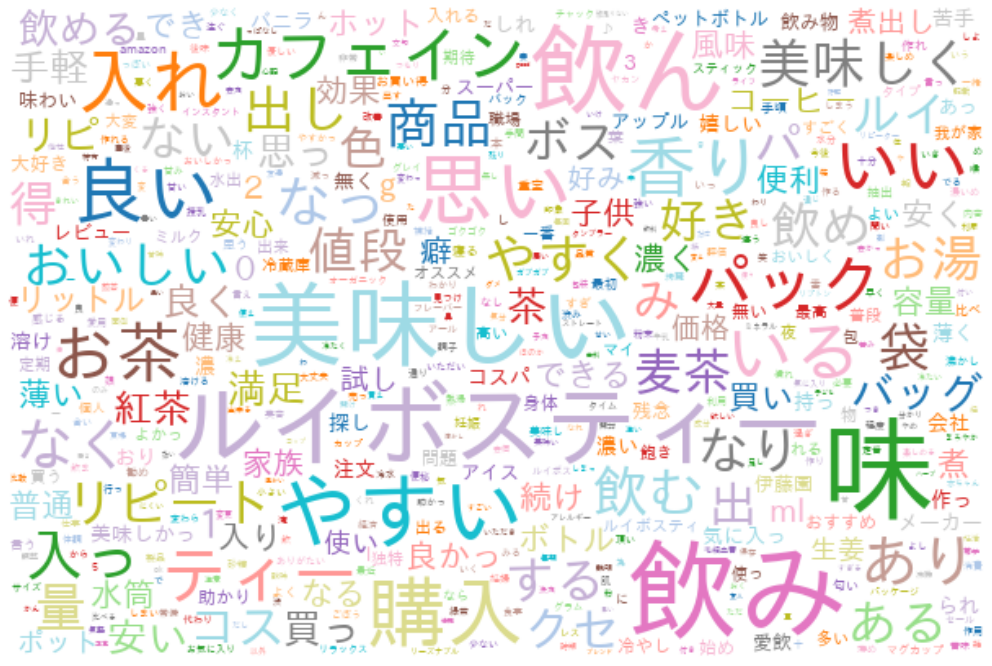

In [132]:
##Split into words and visualize

from sklearn.feature_extraction import stop_words
from collections import Counter, defaultdict
from PIL import Image
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
import MeCab
import sys
import urllib
import nltk
import string
import re
import numpy as np

%matplotlib inline
plt.rcParams["font.family"] = "IPAexGothic"

tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
tagger.parse("")

class CustomMeCabTagger(MeCab.Tagger):

    COLUMNS = ["表層形", "品詞", "品詞細分類1", "品詞細分類2", "品詞細分類3", "活用型", "活用形", "原形", "読み", "発音"]

    def parseToDataFrame(self, text: str) -> pd.DataFrame:
        """テキストを parse した結果を Pandas DataFrame として返す"""
        results = []
        #Mecabの出力方式に基づく。(表層系\t品詞,品詞細分類...)
        #まずは改行で分けて単語自体を区分する
        text_unlisted = " ".join([i for item in text for i in item])
        for line in self.parse(text_unlisted).split("\n"):
            #EOS = end of statement, no more words
            if line == "EOS":
                break
            #Split word itself and feature by "tab"
            surface, feature = line.split("\t")
            #Put None if the content is "*" (means nothing)
            feature = [None if f == "*" else f for f in feature.split(",")]
            results.append([surface, *feature])
        return pd.DataFrame(results, columns=type(self).COLUMNS)

def get_dokuritsugo_by_mecab(text):
    tagger = MeCab.Tagger("/usr/local/lib/mecab/dic/mecab-ipadic-neologd/")
    tagger.parse("") 
    node = tagger.parseToNode(text)
    word_list = []
    while node:
        pos = node.feature.split(",")[0]
        #only needs below (others don't have meanings in this context)
        if pos in ["名詞", "動詞", "形容詞"]:
            word = node.surface
            word_list.append(word)
        node = node.next
    return " ".join(word_list)

df_new["cleared_words"] = df_new["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))

stop_words_all = []
#define stopword (English)
nltk.download("stopwords")
stop_words_sklearn = stop_words.ENGLISH_STOP_WORDS
stop_words_nltk = nltk.corpus.stopwords.words("english")
stop_words_nltk.extend(stop_words_sklearn)
stop_words_all = stop_words_nltk

#define stopword (Japanese)
slothlib_path = "http://svn.sourceforge.jp/svnroot/slothlib/CSharp/Version1/SlothLib/NLP/Filter/StopWord/word/Japanese.txt"
slothlib_file = urllib.request.urlopen(slothlib_path)
slothlib_stopwords = [line.decode("utf-8").strip() for line in slothlib_file]
slothlib_stopwords = [ss for ss in slothlib_stopwords if not ss==u'']
stop_words_all.extend(slothlib_stopwords)

#define manual stopword
add_words=["'",u"それ",u"てる",u"よう",u"こと",u"の",u"し",u"い",u"ん",u"さ",u"て",u"せ",u"れ"]
stop_words_all.extend(add_words)

def del_stop_words(text):
    #replace all the punctuations by using re.sub()
    regex = re.compile('[' +re.escape(string.punctuation) + '0-9\\r\\t\\n]')
    sample = regex.sub("", text)
    
    #change to lower case and check if it's in stop words list
    words = [w.lower()  for w in sample.split(" ") \
                 if not w.lower()  in stop_words_all]
    words=" ".join(words)
    return words

def del_single_used_words(text):
    #delete words only used once
    frequency = defaultdict(int)
    for words in text:
        for token in words:
            frequency[token] += 1
    words = [[token for token in words if frequency[token] > 1] for words in text]
    return words

df_new["cleared_stopwords"] = list(df_new["cleared_words"].apply(lambda x: del_stop_words(x)))
text = del_single_used_words([i.split(" ") for i in df_new["cleared_stopwords"]])

##Make combined list for doc2vec (now also used for LDA&word2Vec)
df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"]=list(df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x)))
text_combined = del_single_used_words([i.split(" ") for i in df_new_combined["cleared_stopwords"]])

#finally make dataframe of wordlist splitted by MeCab
tagger = CustomMeCabTagger()
result = tagger.parseToDataFrame(text_combined)

counter_list = []
for i in result["表層形"]:
    counter_list.append(i)
word_count = Counter(counter_list)

df_count = pd.DataFrame.from_dict(word_count,orient='index').reset_index()
df_count.columns=["word","count"]
df_count.sort_values("count",ascending=False,inplace=True)
df_count = df_count.iloc[1:,:]

print(df_count.head(30))

#Visualization for word count graph
plt.figure(figsize = (30,20))
ax=df_count.iloc[:20,:].plot.bar()
ax.set_ylabel("Frequency",fontsize=15)
ax.set_xticklabels(
    df_count.iloc[:20,:]["word"], fontdict = {
        'fontsize':10})
ax.legend_.remove()
plt.style.use('seaborn-whitegrid')
plt.show()

fpath = "/Users/motoki/opt/anaconda3/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/ipaexg.ttf"
#Visualization for word cloud
wc_bz = WordCloud(
    background_color="white",
    width=600,
    height=400,
    max_words=3000,
    max_font_size=70,
    font_path=fpath,
    prefer_horizontal=1,
    include_numbers=True,
    colormap='tab20',
    regexp=r"[\w']+")
wc_bz.generate_from_frequencies(word_count)

plt.figure(figsize = (21,12))
#sns.set_style("whitegrid")
plt.imshow(wc_bz, interpolation="bilinear")
plt.axis("off")
plt.style.use('seaborn-whitegrid')
plt.show()

In [13]:
# word frequency output to csv

import datetime

now = datetime.datetime.today()
today = now.strftime("%Y%m%d")

output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/amazon"
filename = f"{today}_{category}_review.csv"
df_count.to_csv(f"{output_dir}/{filename}")

df_count

word  count
47       香り   2663
83     美味しい   2180
60       飲み   2102
521   カフェイン   2089
710      紅茶   2043
...     ...    ...
4298    気付き      1
4087    ケージ      1
4258     ｃｃ      1
4295     安さ      1
672     入れれ      1

[4656 rows x 2 columns]

In [14]:
##TF-IDF analysis
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

df_new_combined["cleared_words"] = df_new_combined["combined_title"].apply(lambda x : get_dokuritsugo_by_mecab(x))
df_new_combined["cleared_stopwords"] = df_new_combined["cleared_words"].apply(lambda x: del_stop_words(x))
text_combined_tfidf = [i for i in df_new_combined["cleared_stopwords"]]

vectorizer = TfidfVectorizer()
X=vectorizer.fit_transform(text_combined_tfidf)
X=X.toarray()

idf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
df_idf = pd.DataFrame(columns=['idf']).from_dict(
                    dict(idf), orient='index')
df_idf.columns = ['idf']
display(df_idf.sort_values("idf").head(10).T)

美味しい        紅茶     カフェイン        香り       ティー        思い        購入  \
idf  1.139113  1.169418  1.169418  1.300754  1.318454  1.318454  1.336472   

           飲み        飲ん       好き  
idf  1.373514  1.392562  1.41198

In [94]:
##t-SNE for TF-IDF
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne= TSNE(n_components=2, verbose=1, n_iter=1000)
tsne_tfidf = tsne.fit_transform(X)

[t-SNE] Computing 75 nearest neighbors...
[t-SNE] Indexed 76 samples in 0.001s...
[t-SNE] Computed neighbors for 76 samples in 0.008s...
[t-SNE] Computed conditional probabilities for sample 76 / 76
[t-SNE] Mean sigma: 0.349252
[t-SNE] KL divergence after 250 iterations with early exaggeration: 82.291954
[t-SNE] KL divergence after 1000 iterations: 0.657134


In [95]:
#Put in DataFrame
df_tsne = pd.DataFrame(tsne_tfidf[:,0],columns = ["x"])
df_tsne["y"] = pd.DataFrame(tsne_tfidf[:,1])
df_tsne["product_name"]=df_new_combined.product_name
df_tsne["brand"]=df_new_combined.brand

pd.set_option('display.max_rows', 1000)
display(df_tsne)

x           y                                       product_name  \
0   110.704895 -397.017212  AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末   
1   -58.227531   56.119480  AHMAD TEA ( アーマッドティー ) デカフェ アールグレイ ティーバッグ 100袋...   
2  -135.500656  278.391235  AHMAD TEA ( アーマッドティー ) デカフェ スウィーツティー セレクション ティ...   
3   -34.091301 -424.337189  AHMAD TEA ( アーマッドティー ) デカフェ フルーツセレクション ティーバッグ ...   
4  -132.688339  -88.750740                       AHMAD TEA デカフェフルーツセレクション 40g   
5  -101.874863   35.893345                           AHMAD デカフェアールグレイ 20P 40g   
6    17.237597   21.888826      AZ Tea プレミアムアップルティー 奇跡のリンゴ  紅玉（茶葉）無農薬・カフェインレス   
7  -439.235870 -140.036285               Clipper オーガニック カフェインレス ティー ティーバッグ40個   
8    54.670929   93.629158                 Decafinated Breakfast 20P ペーパーボックス   
9   -38.180321 -173.242325  H&F BELX_プレミアム フレーバーティー_ノンカフェイン_2.5g × 20包 (アー...   
10 -285.061432   31.427563                               NEW やさしいデカフェ紅茶６種類セット   
11  144.702011 -102.208313       PUKKA(パッカ) バニラチャイ 有機 ハーブティー 20TB (オーガニック) 1個   
12 -124.630585 -304.959412                   [5404] DECAF MOMO ティーバッグ10個 パック入   
13 -224.829498 -251.876022  [紅茶の国のアリス]カフェインレス紅茶お試しセット妊婦さん 授乳中 クリスマス プレゼント ...   
14  417.891479 -158.470139                    [紅茶の国のアリス]ノンカフェイン紅茶バラエティーティーセット   
15  186.986053  -89.877922  pukka(パッカ) ハーバルコレクション 有機ハーブティー デカフェ・ノンカフェイン ティ...   
16  -53.455795  -21.857552  【Amazon.co.jp限定】 リプトン アップルカフェインレスティー 60袋入 デカフェ...   
17   16.371691 -215.697266  【Amazon.co.jp限定】 リプトン アップルルイボス 75杯分 デカフェ・ノンカフェ...   
18   27.960945  150.785141  【Amazon.co.jp限定】 リプトン カフェインレスティー 60袋入 デカフェ・ノンカ...   
19 -103.735680 -194.307541  【Amazon.co.jp限定】 リプトン バニラルイボス 75杯分 デカフェ・ノンカフェイ...   
20  195.415131 -205.925735  【まとめ買い】ティーライフ ルイボスティー 101個×2袋セット (ノンカフェイン ルイボス...   
21 -193.567993  213.860596  【セット商品】アーマッドティー デカフェ ティーバッグ アソート 2種 (アールグレイ フル...   
22  440.714417   -6.219740  【セット商品】アーマッドティー ハーブティー ティーバッグ 6種 アソート (ミックスベリー...   
23   53.968834 -131.917572                      ばんどう紅茶 ノンカフェイン 生姜紅茶 60ティーバッグ入   
24 -176.752777  -24.283133                  やさしいデカフェ紅茶 セイロン ティーバッグ10×2袋お試しセット   
25 -303.932220 -145.985550                やさしいデカフェ紅茶_アールグレイ_ティーバッグ10×2袋お試しセット   
26 -396.142365  231.406784                  やさしいデカフェ紅茶_ピーチ_三角ティーバッグ10入り×2袋セット   
27  271.438599   86.027695               やさしいデカフェ紅茶_マスカットフレーバー_ティーバッグ10×2袋セット   
28  199.455338  313.613037           やさしいデカフェ紅茶_水出しアールグレイ_500ml用ティーバッグ7×3袋セット   
29  303.753632 -203.171066                                やさしいデカフェ紅茶_水出し３袋セット   
30  -90.933876  357.787781                       やさしいデカフェ紅茶マスカット 1.2g×10TB×6袋   
31 -139.837418 -380.959442       アサヒグループ食品 和光堂牛乳屋さんのカフェインレスミルクティー320g 320g×3個   
32 -258.997833  -42.441452  アリスの謎解きティーレター（6種のカフェインレス紅茶、アールグレイ、アップルティー、ピーチテ...   
33  -31.983131  457.092834            アーマッドティー_デカフェ アールグレイ ティー（PET）_500ml×24本   
34  157.773041 -272.089172     オーガニック ルイボスティー 特級エクストラファイン 有機JAS ティーバッグ 3g×50包   
35  242.786758 -291.206696  オーガライフ ラズベリーリーフティー オーガニック 1.2g×30包 ティーバッグ ドイツオ...   
36  385.103119 -321.859070              カフェインレス紅茶 ピーチ（ひもつきティーバッグ１０個入）紅茶の国のアリス   
37 -495.497009   59.143970  カフェインレス紅茶 選べる3点ギフトセット・箱入りプレゼント包装済み（妊婦さん・授乳中の方・...   
38 -460.682556   85.994949  カフェインレス紅茶 選べる3点ギフトセット・箱入りプレゼント包装済み（妊婦さん・授乳中の方・...   
39  120.587021  265.479767               キリン 午後の紅茶 デカフェ ストレートティー 500mlPET×24本   
40   -7.550980   95.452209  クリッパー〔認定〕 アッサムブレンド カフェインレス 50g (20×2.5gティーバッグ)...   
41  197.448227  -18.907467  ゾネントア SONNENTOR ハーブティー オーガニック ティーバッグ アソート 20種類のお茶   
42 -362.443756  -41.009888  ティーブティック やさしいデカフェ 紅茶 ノンカフェイン フルーツシリーズ 8種セット 各1袋ずつ   
43   17.804901  324.599548                  ティーブティック やさしいデカフェ紅茶 アールグレイ 12g×6袋   
44 -202.700699 -135.542099         ティーブティック やさしいデカフェ紅茶 ノンカフェイン フルーツシリーズ 6種セット   
45  127.186821 -225.922211  ティーライフ ルイボスティー 2.0g×101個 (ノンカフェイン ルイボス茶 水出し お茶...   
46   16.155296  -62.235214    トワイニング アール グレイ ルイボス 20P ×2箱 デカフェ・ノンカフェイン ティーバッグ   
47   41.681576  239.761887                          トワイニング カフェインレス アールグレイ 20P   
48 -112.342537   95.363510                  

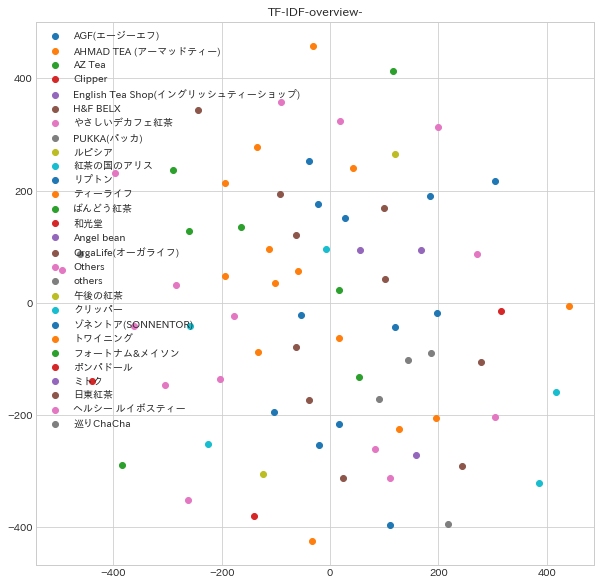

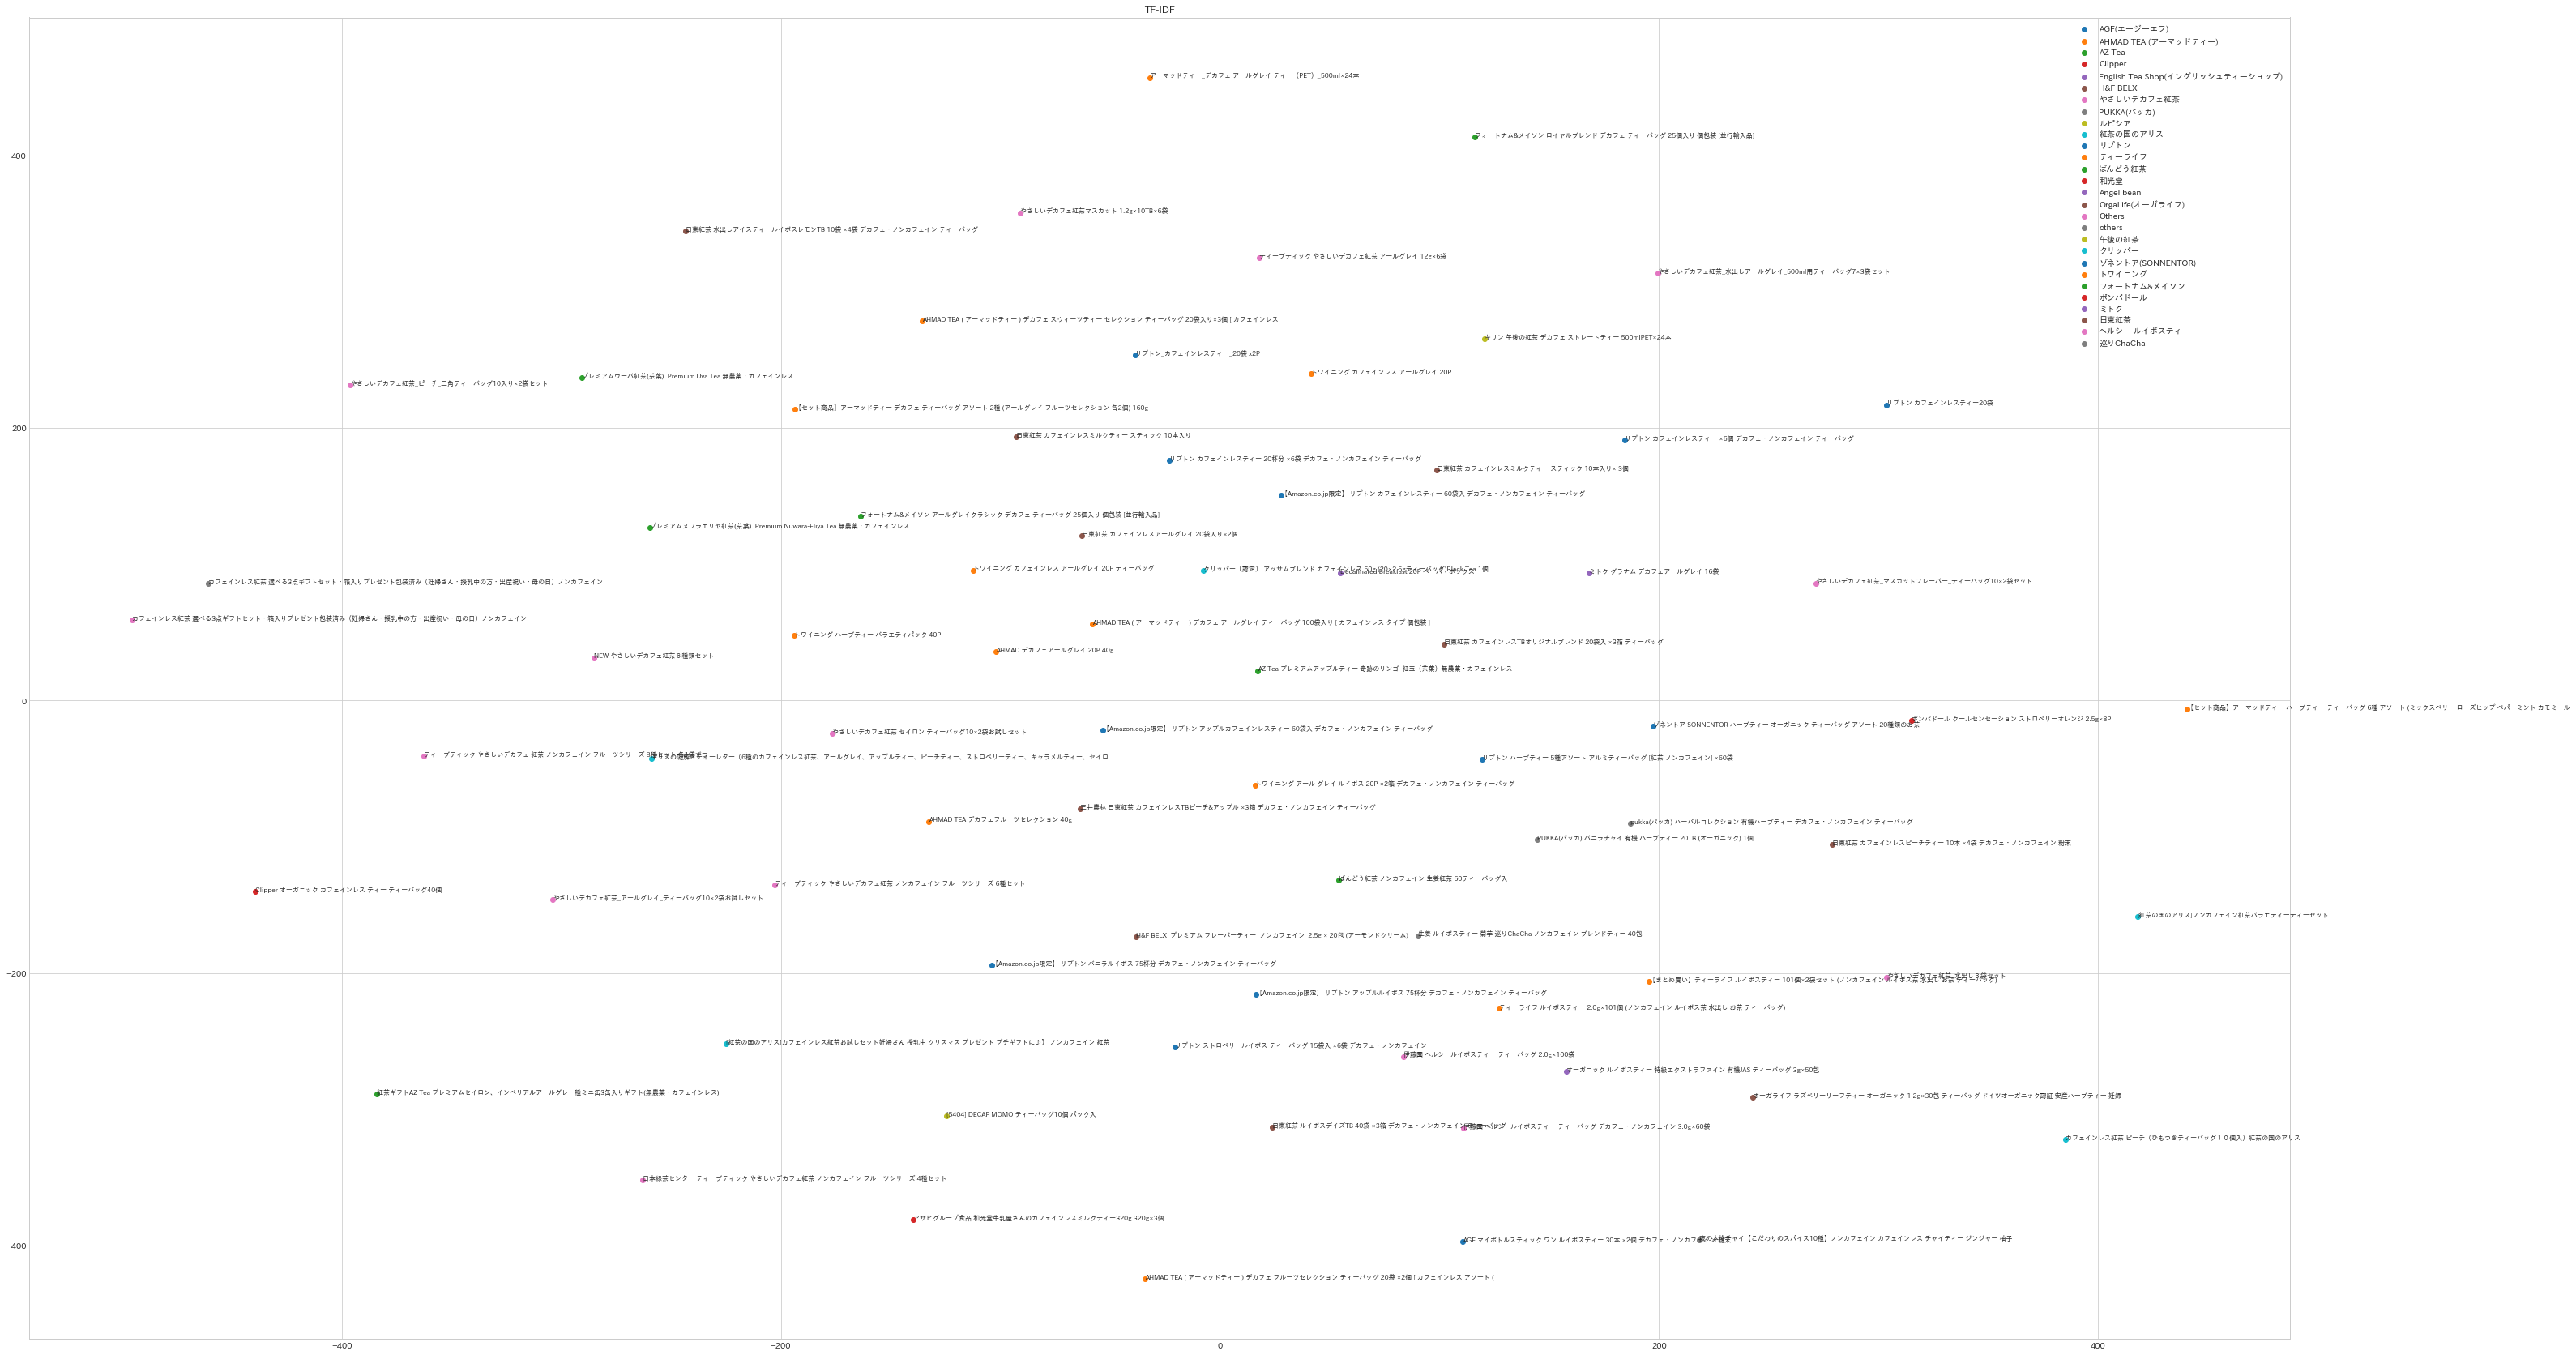

In [96]:
##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

plt.legend()
plt.title("TF-IDF-overview-")
plt.show()

#B: Detail
fig_detail = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne['brand'].unique():
    plt.scatter(df_tsne.loc[df_tsne.brand == f ,'x'], df_tsne.loc[df_tsne.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne["product_name"].values):
    plt.annotate(txt, (df_tsne["x"].values[i], df_tsne["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("TF-IDF")
plt.show()

In [28]:
##LDA analytics (after filtering TF-IDF)

import gensim
from gensim import corpora, models

#Dictionary is the set of "word ID, word, frequency" data (can be saved)
dictionary =corpora.Dictionary(text)
corpus = [dictionary.doc2bow(doc) for doc in text_combined]

#Can filter TF-IDF before LDA
#TF = Term Frequency -> frequency of each word (the bigger, the more important)
#IDF = Inverse document frequency -> filtering too high frequent words like "a, the, there etc.."
#Below is the class for TF-IDF analytics
#tfidf = gensim.models.TfidfModel(corpus)
#corpus_tfidf = tfidf[corpus]

#Number of topics
zk = 7
#Learning model (can be saved)
lda = gensim.models.LdaModel(corpus=corpus, id2word=dictionary,
                             num_topics=zk, minimum_probability=0.001,
                             passes=20, update_every=0, chunksize=10000)

for i in range(zk):
    print('tpc_{0}: {1}'.format(i, lda.print_topic(i)[0:80]+'...'))

tpc_0: 0.026*"" + 0.018*"飲み" + 0.017*"味" + 0.015*"美味しい" + 0.012*"飲ん" + 0.008*"購入" + 0.0...
tpc_1: 0.002*"休み" + 0.002*"忘れ" + 0.002*"毎度" + 0.002*"たまり" + 0.002*"可愛く" + 0.002*"いちご" +...
tpc_2: 0.028*"味" + 0.024*"" + 0.024*"香り" + 0.019*"ティー" + 0.016*"ハーブ" + 0.015*"美味しい" + 0...
tpc_3: 0.039*"紅茶" + 0.035*"香り" + 0.031*"カフェイン" + 0.028*"" + 0.025*"味" + 0.018*"美味しい" + ...
tpc_4: 0.051*"" + 0.025*"味" + 0.025*"飲み" + 0.021*"飲ん" + 0.019*"美味しい" + 0.018*"ルイボスティー" ...
tpc_5: 0.030*"飲み" + 0.026*"味" + 0.020*"生姜" + 0.017*"飲ん" + 0.015*"美味しい" + 0.014*"" + 0.0...
tpc_6: 0.030*"ルイボスティー" + 0.024*"アップル" + 0.021*"" + 0.019*"香り" + 0.019*"飲み" + 0.018*"ティー...


product_name    Prob_1    Prob_2  \
0   AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末  0.000034  0.000034   
1   AHMAD TEA ( アーマッドティー ) デカフェ アールグレイ ティーバッグ 100袋...  0.000012  0.000012   
2   AHMAD TEA ( アーマッドティー ) デカフェ スウィーツティー セレクション ティ...  0.000306  0.000305   
3   AHMAD TEA ( アーマッドティー ) デカフェ フルーツセレクション ティーバッグ ...  0.001560  0.077700   
4                        AHMAD TEA デカフェフルーツセレクション 40g  0.000422  0.000420   
5                            AHMAD デカフェアールグレイ 20P 40g  0.000006  0.000006   
6       AZ Tea プレミアムアップルティー 奇跡のリンゴ  紅玉（茶葉）無農薬・カフェインレス  0.001165  0.001162   
7                Clipper オーガニック カフェインレス ティー ティーバッグ40個  0.001249  0.001243   
8                  Decafinated Breakfast 20P ペーパーボックス  0.000267  0.000266   
9   H&F BELX_プレミアム フレーバーティー_ノンカフェイン_2.5g × 20包 (アー...  0.000131  0.000130   
10                               NEW やさしいデカフェ紅茶６種類セット  0.000697  0.000694   
11       PUKKA(パッカ) バニラチャイ 有機 ハーブティー 20TB (オーガニック) 1個  0.000022  0.000022   
12                   [5404] DECAF MOMO ティーバッグ10個 パック入  0.001004  0.000999   
13  [紅茶の国のアリス]カフェインレス紅茶お試しセット妊婦さん 授乳中 クリスマス プレゼント ...  0.915915  0.000946   
14                    [紅茶の国のアリス]ノンカフェイン紅茶バラエティーティーセット  0.687710  0.001051   
15  pukka(パッカ) ハーバルコレクション 有機ハーブティー デカフェ・ノンカフェイン ティ...  0.000022  0.000022   
16  【Amazon.co.jp限定】 リプトン アップルカフェインレスティー 60袋入 デカフェ...  0.000123  0.000123   
17  【Amazon.co.jp限定】 リプトン アップルルイボス 75杯分 デカフェ・ノンカフェ...  0.000103  0.000103   
18  【Amazon.co.jp限定】 リプトン カフェインレスティー 60袋入 デカフェ・ノンカ...  0.000079  0.000079   
19  【Amazon.co.jp限定】 リプトン バニラルイボス 75杯分 デカフェ・ノンカフェイ...  0.000085  0.000085   
20  【まとめ買い】ティーライフ ルイボスティー 101個×2袋セット (ノンカフェイン ルイボス...  0.000238  0.000238   
21  【セット商品】アーマッドティー デカフェ ティーバッグ アソート 2種 (アールグレイ フル...  0.001646  0.001643   
22  【セット商品】アーマッドティー ハーブティー ティーバッグ 6種 アソート (ミックスベリー...  0.893701  0.003485   
23                      ばんどう紅茶 ノンカフェイン 生姜紅茶 60ティーバッグ入  0.000508  0.000507   
24                  やさしいデカフェ紅茶 セイロン ティーバッグ10×2袋お試しセット  0.000376  0.000375   
25                やさしいデカフェ紅茶_アールグレイ_ティーバッグ10×2袋お試しセット  0.000680  0.000677   
26                  やさしいデカフェ紅茶_ピーチ_三角ティーバッグ10入り×2袋セット  0.000937  0.000934   
27               やさしいデカフェ紅茶_マスカットフレーバー_ティーバッグ10×2袋セット  0.008428  0.008404   
28           やさしいデカフェ紅茶_水出しアールグレイ_500ml用ティーバッグ7×3袋セット  0.002555  0.002552   
29                                やさしいデカフェ紅茶_水出し３袋セット  0.000727  0.000725   

      Prob_3    Prob_4    Prob_5    Prob_6    Prob_7  Max  
0   0.611220  0.000034  0.388610  0.000034  0.000034    3  
1   0.000012  0.999918  0.000020  0.000012  0.000012    4  
2   0.482501  0.515967  0.000307  0.000306  0.000307    4  
3   0.001562  0.914503  0.001559  0.001558  0.001559    4  
4   0.629219  0.368672  0.000422  0.000422  0.000422    3  
5   0.000006  0.999812  0.000157  0.000006  0.000006    4  
6   0.093905  0.671954  0.001166  0.001166  0.229482    4  
7   0.445544  0.181263  0.001247  0.368208  0.001246    3  
8   0.119935  0.858567  0.000267  0.000267  0.020431    4  
9   0.561761  0.067749  0.276222  0.000130  0.093877    3  
10  0.562064  0.434456  0.000697  0.000696  0.000696    3  
11  0.999868  0.000022  0.000022  0.000022  0.000022    3  
12  0.451930  0.543057  0.001005  0.001003  0.001002    4  
13  0.000949  0.079345  0.000949  0.000948  0.000948    1  
14  0.001055  0.307021  0.001055  0.001054  0.001053    1  
15  0.999868  0.000022  0.000022  0.000022  0.000022    3  
16  0.220011  0.458445  0.076235  0.083945  0.161118    4  
17  0.157989  0.043370  0.449924  0.000103  0.348408    5  
18  0.000079  0.628090  0.063059  0.308535  0.000079    4  
19  0.503216  0.194849  0.196637  0.000086  0.105043    3  
20  0.000238  0.000239  0.998570  0.000238  0.000238    5  
21  0.350860  0.640905  0.001649  0.001648  0.001648    4  
22  0.003495  0.088841  0.003494  0.003492  0.003491    1  
23  0.000509  0.331627  0.282478  0.383862  0.000509    6  
24  0.000377  0.997743  0.000377  0.000376  0.000376    4  
25  0.000680  0.995924  0.000680  0.000679  0.000679    4  
26  0.337028  0.658290  0.000939 

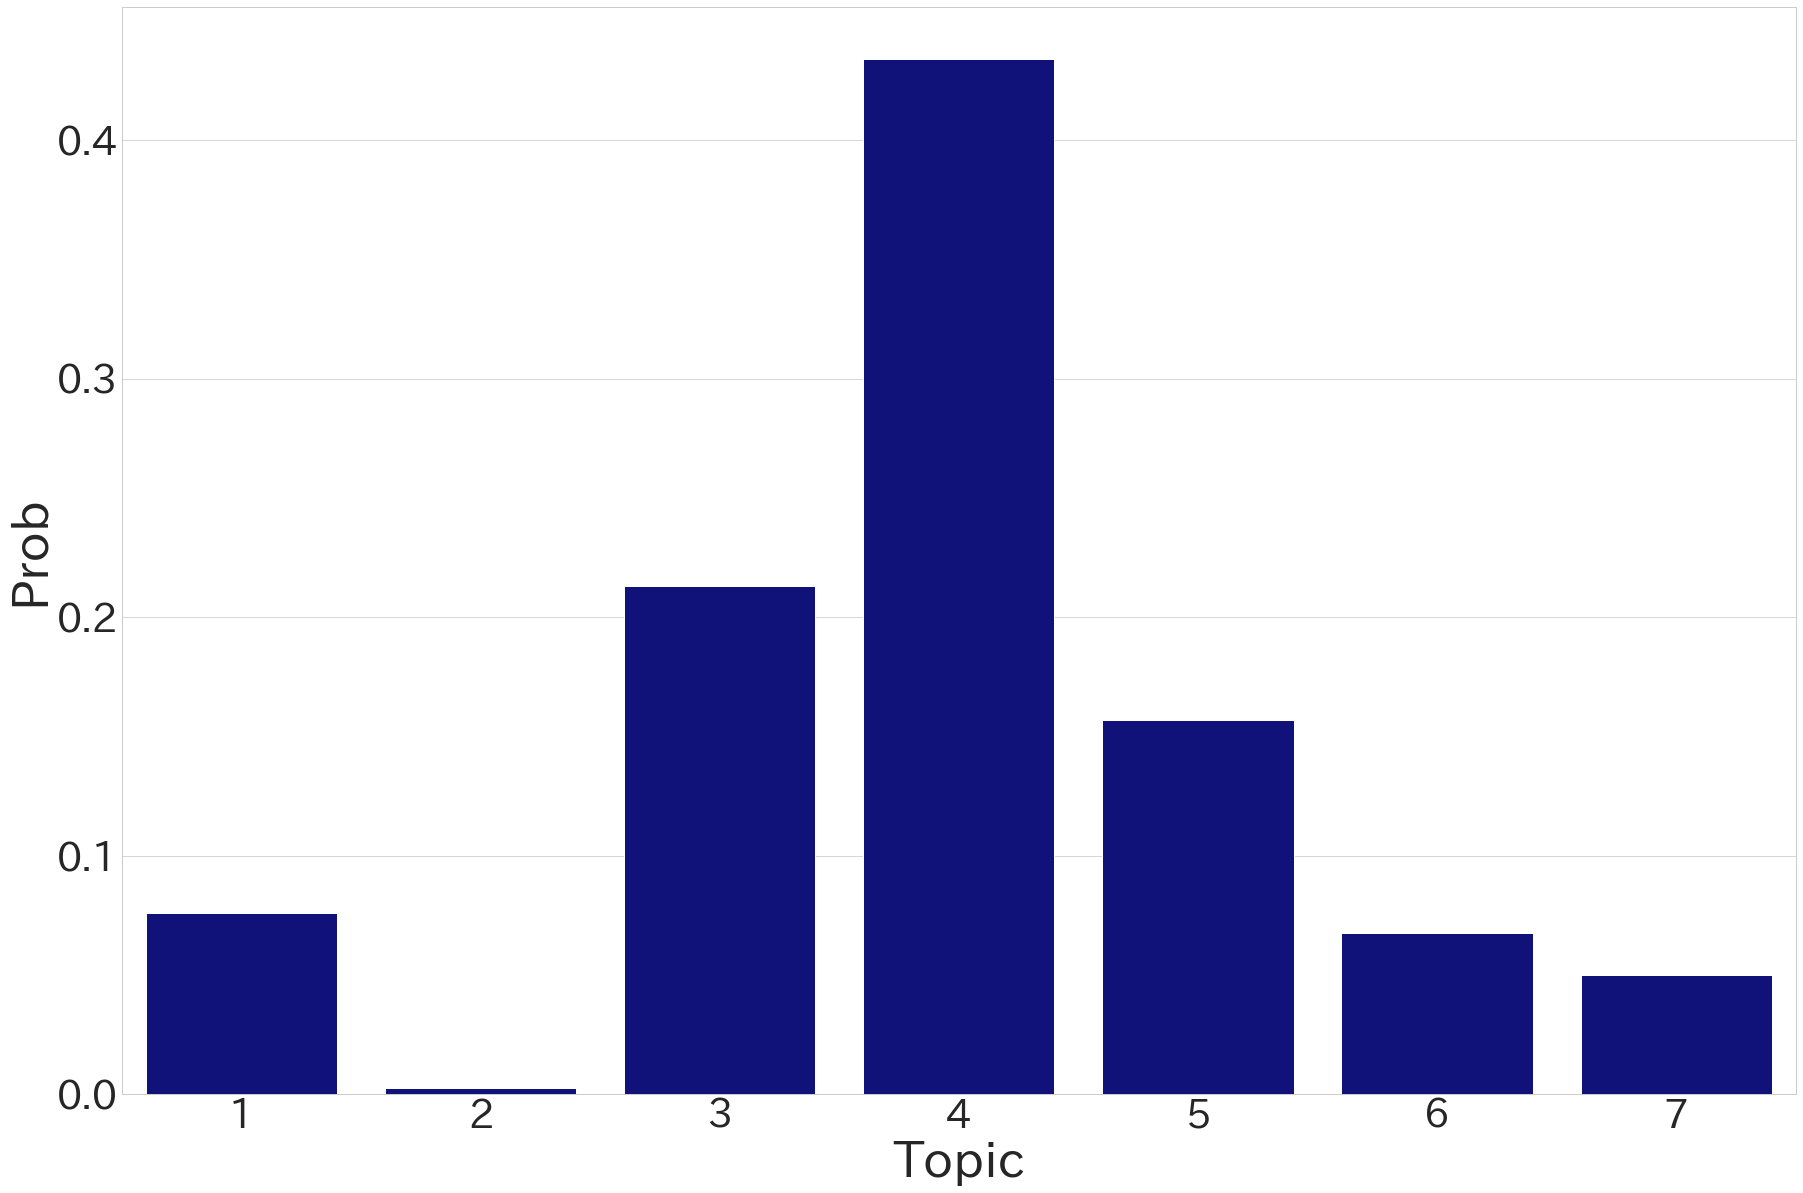

In [90]:
#Make Numpy b/w Products & topics
Prob_products=np.array(lda.get_document_topics(corpus,minimum_probability=0))[:,:,1]

#Put in DataFrame
L=[ z for z in range(1,zk+1)]
col_name=list(map(lambda x: "Prob_"+str(x),L))
df_prob=pd.DataFrame(Prob_products)
df_prob.columns=col_name

#Add product name & most likely belonging topic No.
df_prob["Max"]=df_prob.idxmax(axis=1)
def del_Prob(x):
    return int(x.split("_")[1])
df_prob["Max"]=df_prob["Max"].apply(lambda x : del_Prob(x))
df_prob.insert(0, "product_name", df_new_combined["product_name"])
display(df_prob.head(30))

#Calculate probability of apperance of each topic
df_topic=pd.DataFrame(df_prob.drop(["Max", "product_name"],axis=1).sum()/df_prob.drop(["Max", "product_name"],axis=1).sum().sum())
df_topic.columns=["Prob"]
df_topic["Topic"]=[ z for z in range(1,zk+1)]

#Visualization
plt.figure(figsize = (30,20))
ax= sns.barplot(x="Topic",y="Prob",data=df_topic,color="darkblue")
ax.set_xlabel("Topic",fontsize=50)
ax.set_ylabel("Prob",fontsize=50)
ax.tick_params(axis='x', labelsize=40)
ax.tick_params(axis='y', labelsize=40)
plt.show()

<Figure size 1512x864 with 0 Axes>

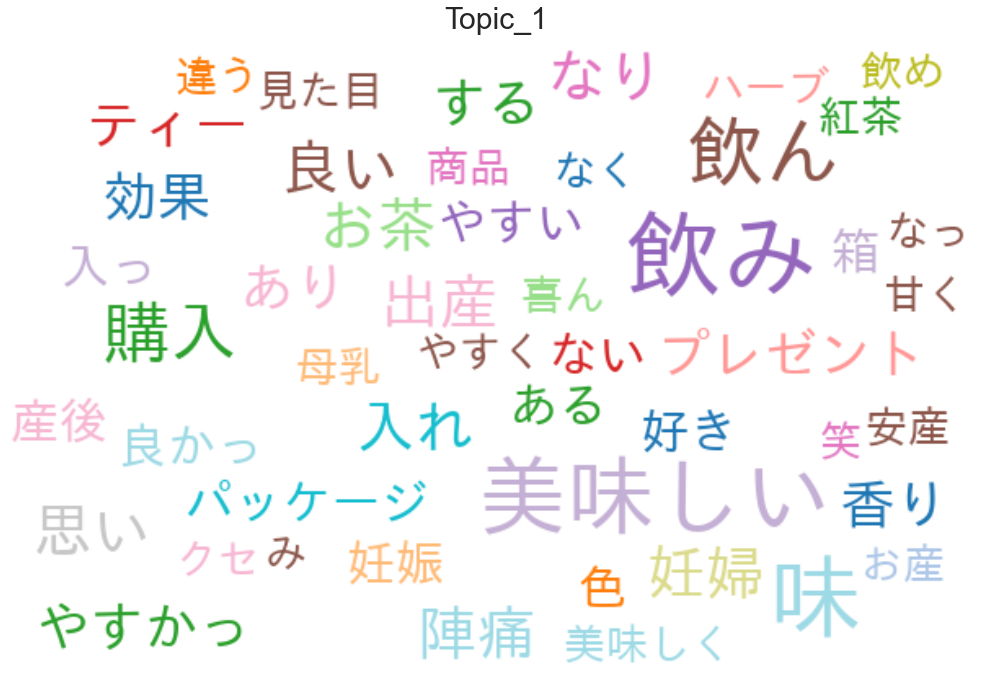

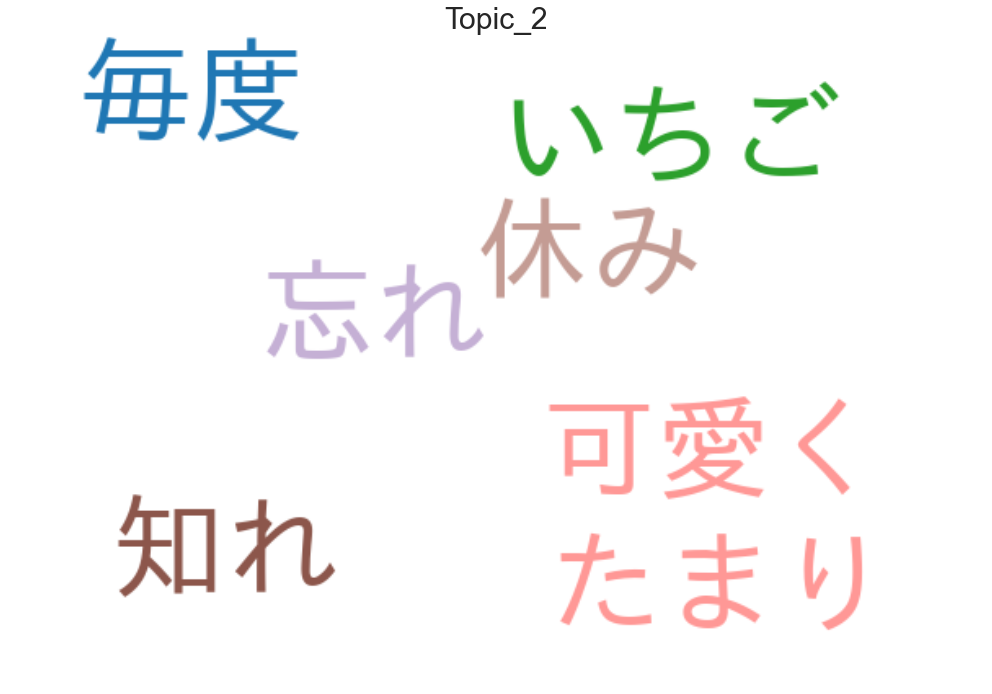

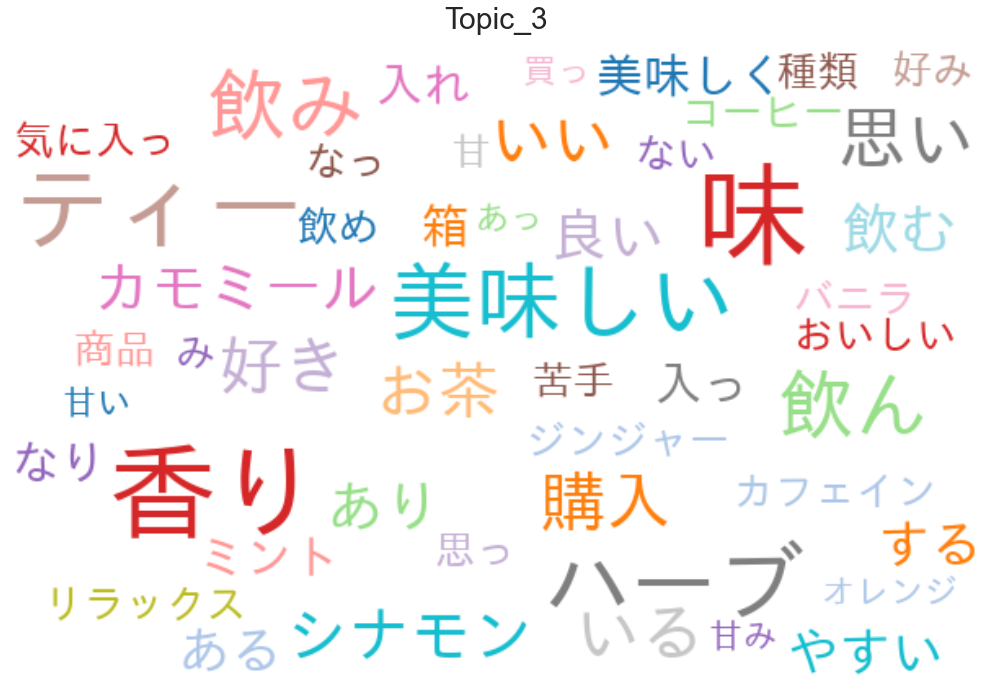

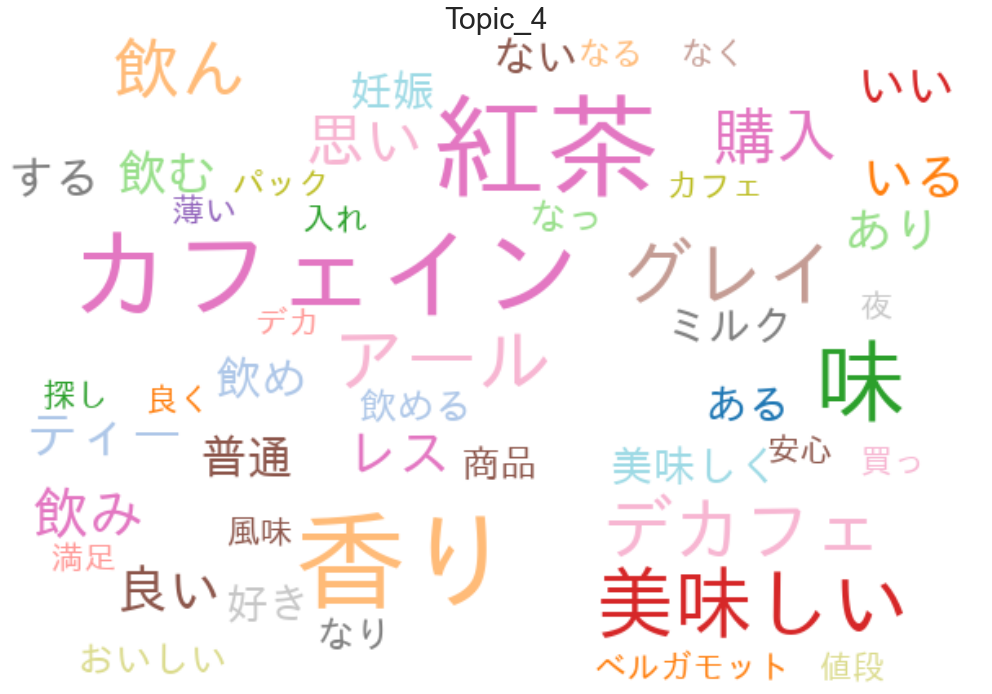

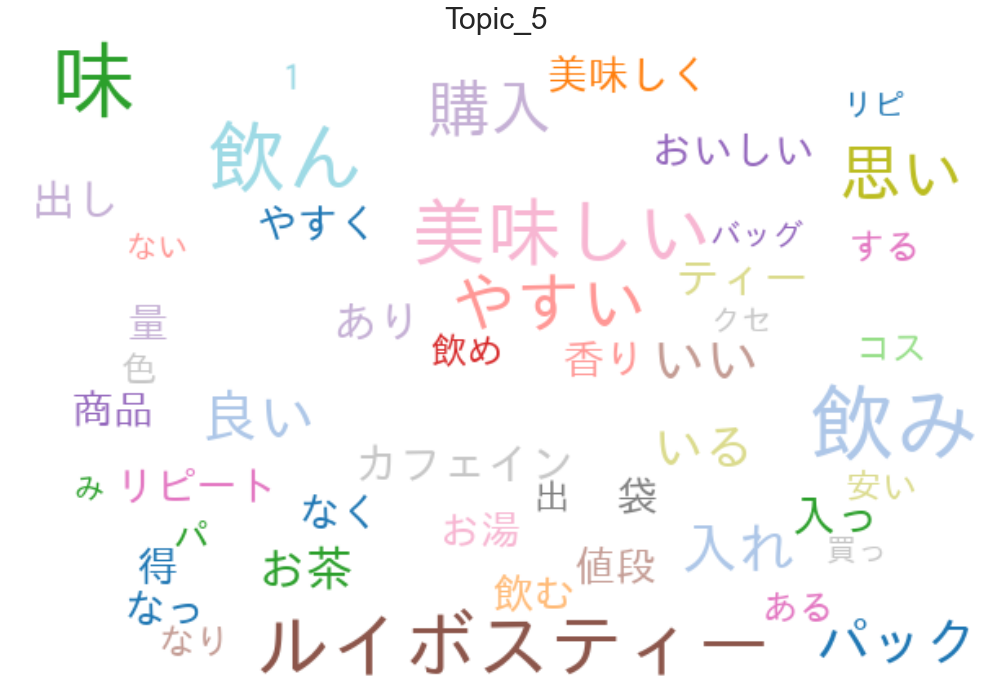

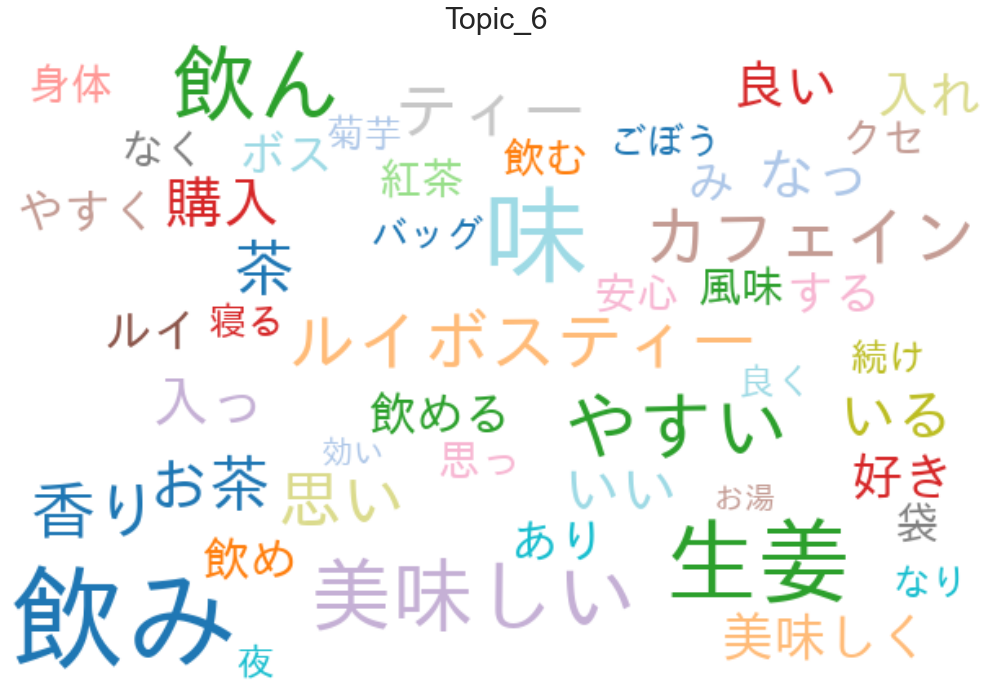

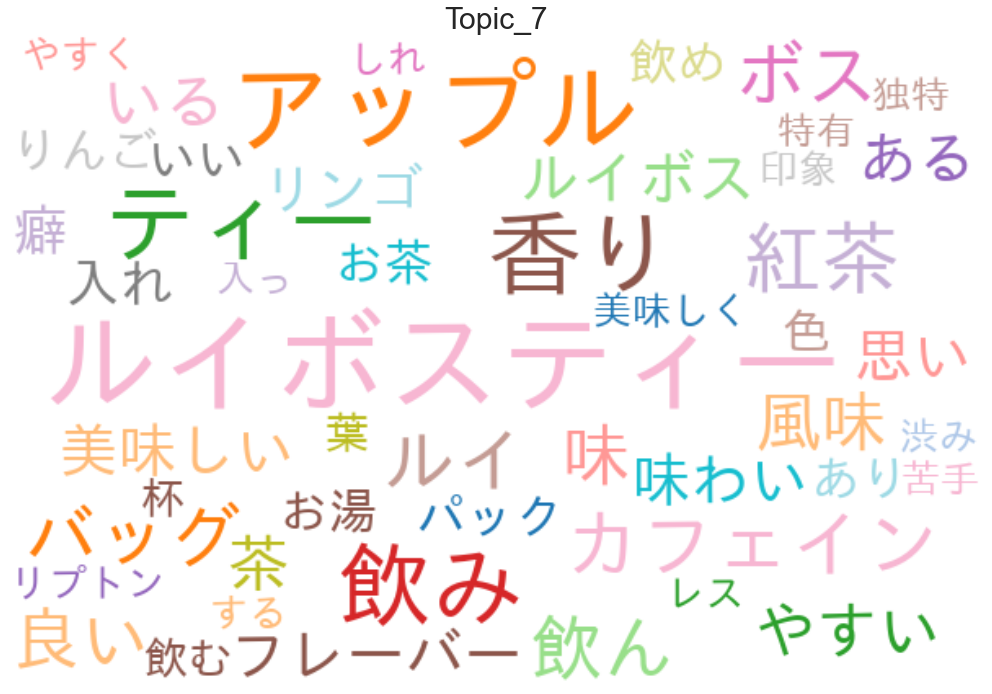

In [30]:
##Visualization of words

topic_word_prob=[]

for z in range(zk):
    word=[]
    prob=[]
    topic = lda.show_topic(z,1000) #No. of words

    for t in topic:
        word.append(t[0])
        prob.append(t[1])
        
    df_lda=pd.DataFrame({"word":word,"prob":prob})
    topic_word_prob.append(df_lda)

fig = plt.figure(figsize=(21, 12))

for z in range(zk):
    topic_text=[]
    for index, row in topic_word_prob[z].iloc[:2000,].iterrows():
        word=row["word"]
        weight=int(row["prob"]*1000)
        for _ in range(weight):
            topic_text.append(word)
            
    words = Counter(topic_text)
    wc_bz = WordCloud(background_color="white",
                      width=600, 
                      height=400, 
                      max_words=50, 
                      max_font_size=70, 
                      font_path=fpath,
                      prefer_horizontal=1,
                      include_numbers=True,
                      colormap='tab20',
                      regexp=r"[\w']+")
    wc_bz.generate_from_frequencies(words)

    plt.figure(figsize = (21,12))
    sns.set_style("whitegrid")
    plt.title('Topic_{}'.format(z+1), fontsize=30)
    plt.imshow(wc_bz, interpolation='bilinear')
    plt.axis("off")
    
    # topic groups output to png
    output_dir = "/Users/motoki/PycharmProjects/motoki_ul/review_analysis/output_dir/amazon"
    pngname =  f"{today}_{category}_{zk}topics"
    plt.savefig(f'{output_dir}/{pngname}_{z+1}.png')
    plt.show()

In [70]:
##Word2Vec Analysis
from gensim.models import word2vec

sent = text_combined
#Learning word2vec model
model = word2vec.Word2Vec(sent,
                          vector_size=50,  # Demention of vector (depends on the number of unique words)
                          min_count=2,  # Words appearing at least 2 times
                          window=5,  # Width of window
                          epochs=4000,  # Iter numbers of leaning
                          seed=2018 # Fix seed for generating stable random number
                         )

In [71]:
word = "夜"
# Output the most similar words & similarity index
results = model.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_夜_


0        1         2         3         4         5         6   \
Word        授乳       利尿        デス         ♪      アイテム       トイレ        頻繁   
Sim   0.477836  0.46559  0.451091  0.439732  0.439095  0.427556  0.425043   

            7         8         9         10        11        12        13  \
Word        酸味         す   インフルエンザ        妨げ        気味        眠る        就寝   
Sim   0.417126  0.399962  0.398778  0.396937  0.392279  0.390266  0.386133   

           14        15        16        17        18        19  
Word       だれ        動悸        食べ        頼ん        たて        ンレ  
Sim   0.38548  0.384628  0.384141  0.374509  0.374413  0.372153

In [72]:
## Plus/Minus words and show the similarities
results = model.wv.most_similar(positive=[u"ルイボスティー",u"美味しい"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2        3         4         5         6   \
Word        飲み      美味しく      リピート     おいしい        飲ん        今後         味   
Sim   0.638859  0.608489  0.542307  0.52703  0.507336  0.480674  0.476119   

            7         8         9         10        11        12        13  \
Word       やすい        お茶      受け付け        購入        思い     美味しかっ        子供   
Sim   0.473347  0.453146  0.413017  0.392631  0.390928  0.376487  0.375107   

            14        15        16        17        18        19  
Word    ルイボスティ        通じ        容量        登山       代わり        麦茶  
Sim   0.374967  0.373728  0.372173  0.360876  0.357551  0.352564

In [73]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    #print(df_new_combined.product[i])
    feature_vec = np.zeros(50)
    num_words = 0
    for word in product:
        try:
            feature_vec += model.wv[word]
            num_words += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec = feature_vec / num_words  # Split sum of all the words vector
    product_vec[i] = feature_vec

##t-SNE for Word2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=500)
tsne_word2vec = tsne.fit_transform(product_vec)

[t-SNE] Computing 75 nearest neighbors...
[t-SNE] Indexed 76 samples in 0.000s...
[t-SNE] Computed neighbors for 76 samples in 0.004s...
[t-SNE] Computed conditional probabilities for sample 76 / 76
[t-SNE] Mean sigma: 3.002366
[t-SNE] KL divergence after 250 iterations with early exaggeration: 57.753956
[t-SNE] KL divergence after 500 iterations: 0.741862


x          y                                            product  \
0  42.423866  67.840149  AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末   
1 -16.799992  -5.995493  AHMAD TEA ( アーマッドティー ) デカフェ アールグレイ ティーバッグ 100袋...   
2   2.983600 -20.955715  AHMAD TEA ( アーマッドティー ) デカフェ スウィーツティー セレクション ティ...   
3 -35.808601 -33.692551  AHMAD TEA ( アーマッドティー ) デカフェ フルーツセレクション ティーバッグ ...   
4 -37.784119  14.594618                       AHMAD TEA デカフェフルーツセレクション 40g   
5 -22.876429   0.886275                           AHMAD デカフェアールグレイ 20P 40g   
6  64.275909  27.384722      AZ Tea プレミアムアップルティー 奇跡のリンゴ  紅玉（茶葉）無農薬・カフェインレス   
7  41.138371 -32.500591               Clipper オーガニック カフェインレス ティー ティーバッグ40個   
8 -24.383598 -24.909241                 Decafinated Breakfast 20P ペーパーボックス   
9  24.882460   6.162048  H&F BELX_プレミアム フレーバーティー_ノンカフェイン_2.5g × 20包 (アー...   

                              brand  
0                       AGF(エージーエフ)  
1              AHMAD TEA (アーマッドティー)  
2              AHMAD TEA (アーマッドティー)  
3              AHMAD TEA (アーマッドティー)  
4              AHMAD TEA (アーマッドティー)  
5              AHMAD TEA (アーマッドティー)  
6                            AZ Tea  
7                           Clipper  
8  English Tea Shop(イングリッシュティーショップ)  
9                          H&F BELX

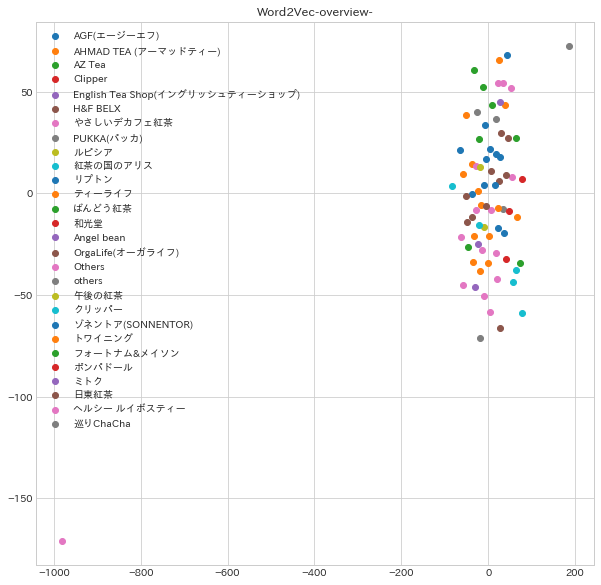

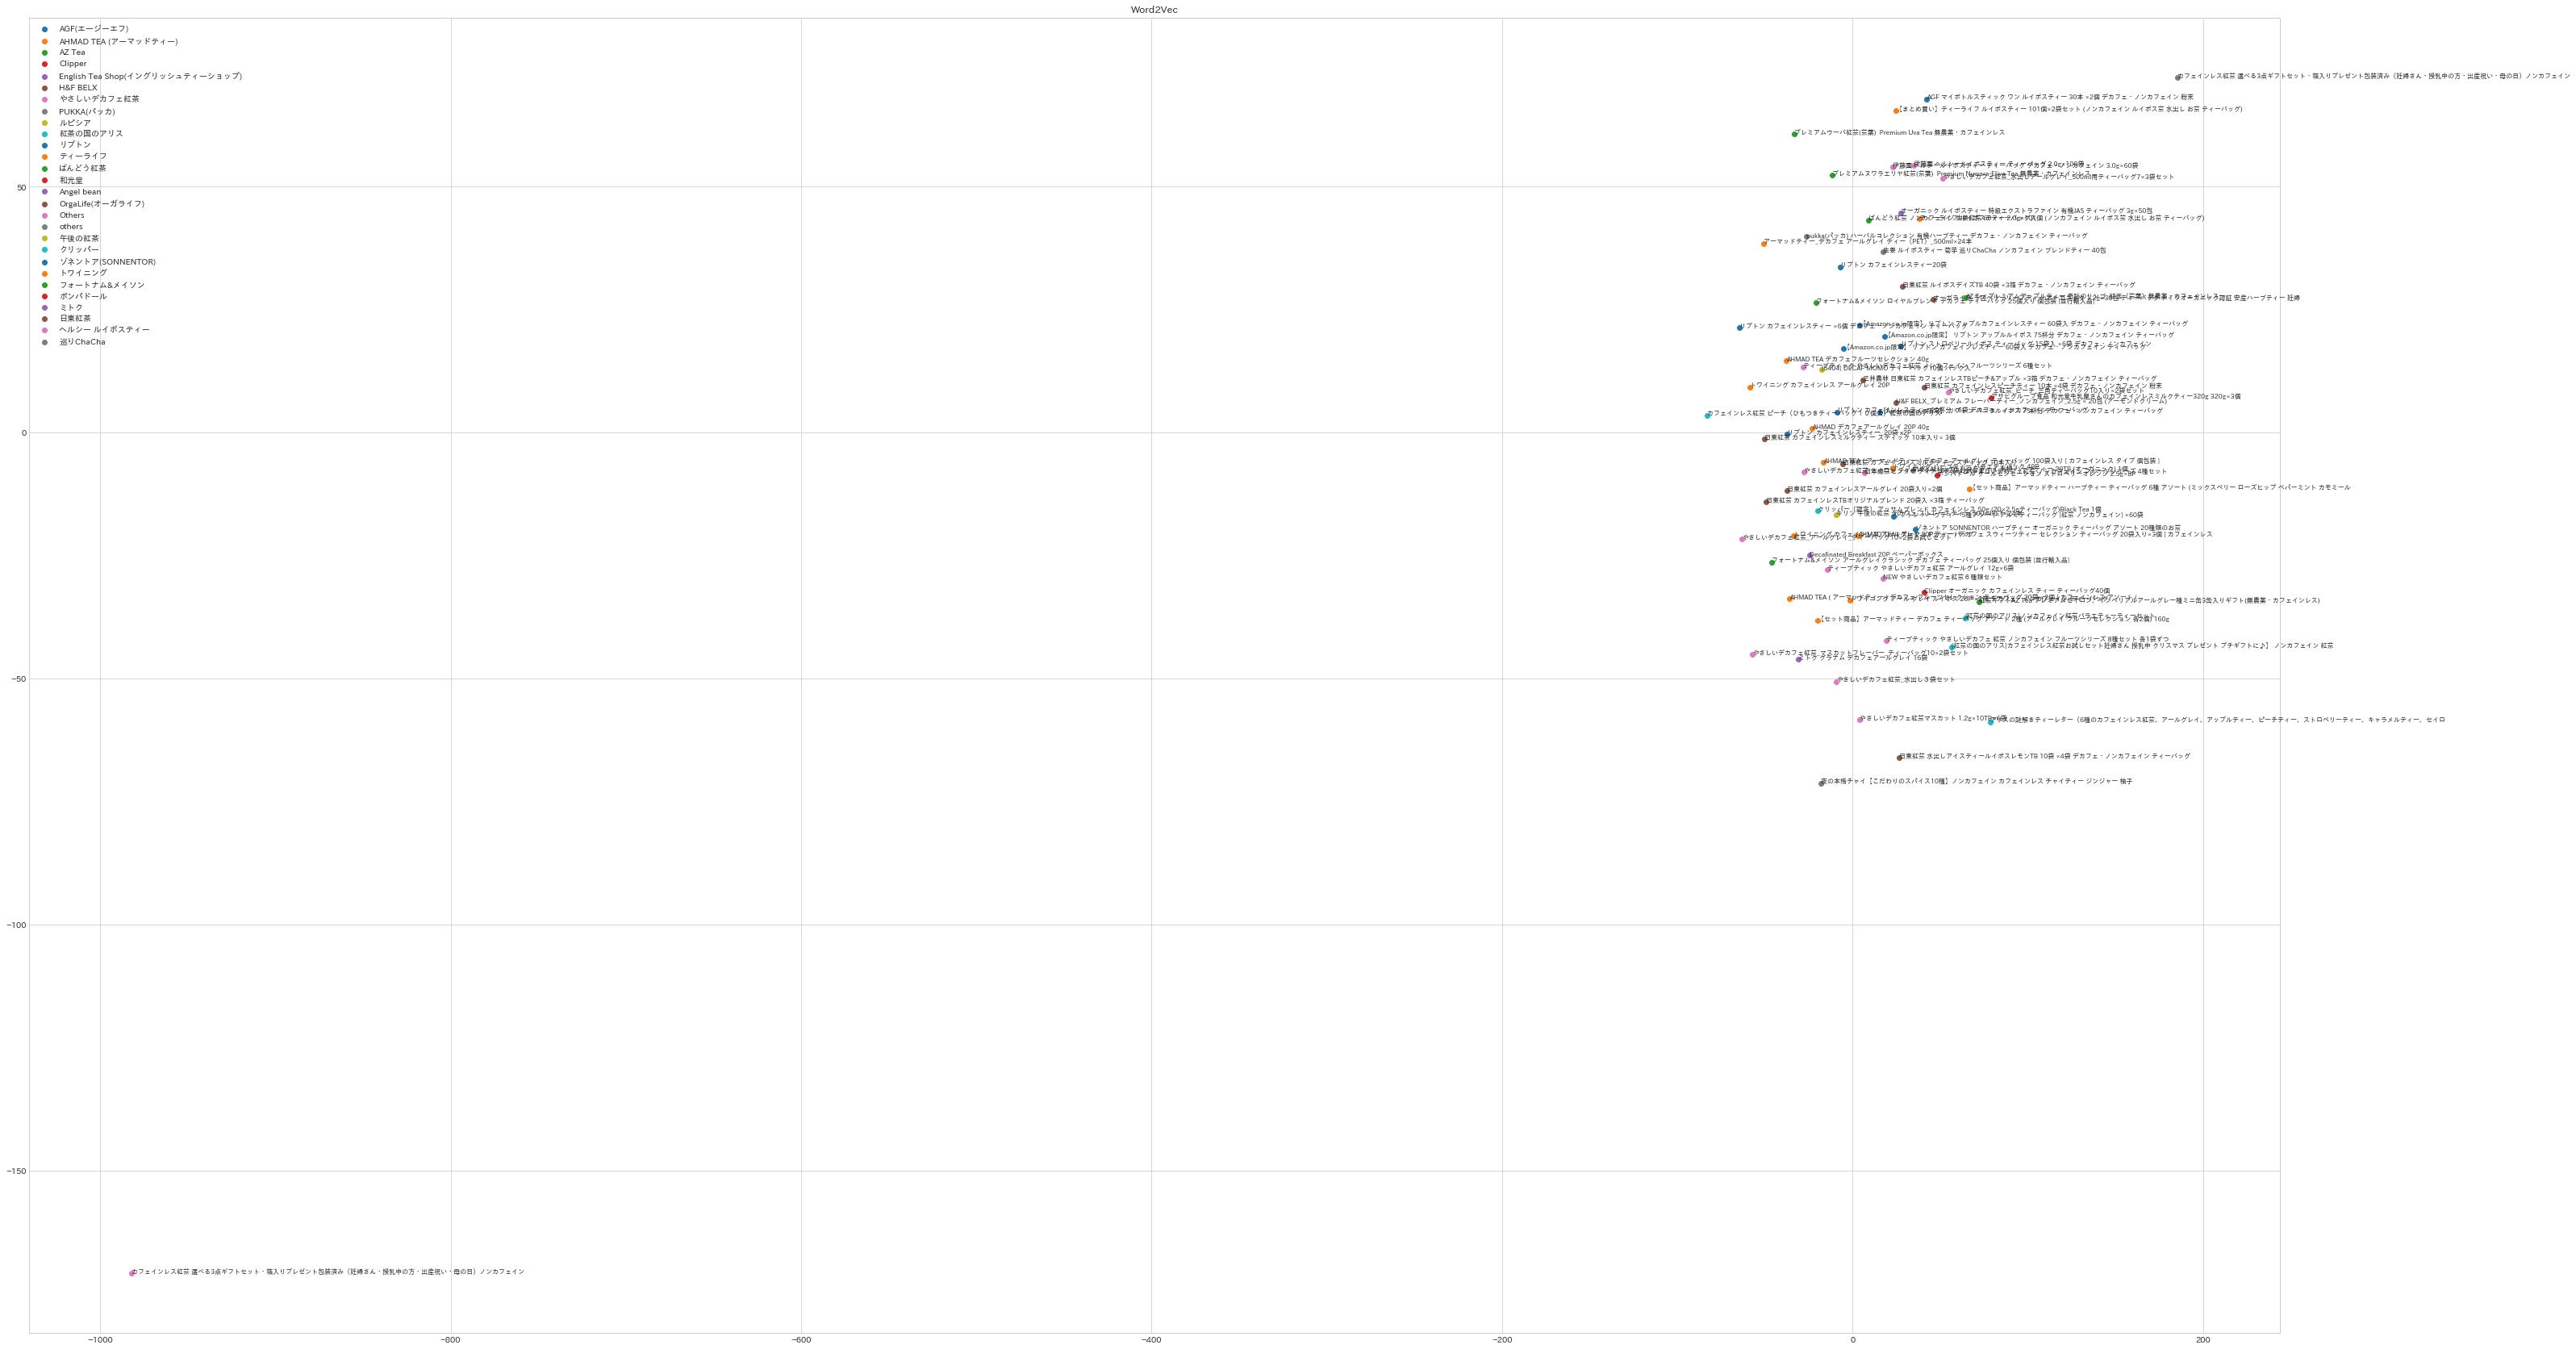

In [89]:
#Put in DataFrame
df_tsne_word2vec = pd.DataFrame(tsne_word2vec[:, 0],columns = ["x"])
df_tsne_word2vec["y"] = pd.DataFrame(tsne_word2vec[:, 1])
df_tsne_word2vec["product"] = df_new_combined.product_name 
df_tsne_word2vec["brand"] = df_new_combined.brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_word2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_word2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Word2Vec-overview-")

#B: Detail
fig_detail_word2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_word2vec['brand'].unique():
    plt.scatter(df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'x'], df_tsne_word2vec.loc[df_tsne_word2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_word2vec["product"].values):
    plt.annotate(txt, (df_tsne_word2vec["x"].values[i], df_tsne_word2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Word2Vec")

plt.show()

In [97]:
##Doc2Vec analysis

from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
from gensim import corpora, models

trainings_combined = [TaggedDocument(words=data, tags=[name]) for (name, data) in zip(df_new_combined["product_name"], text_combined)]

# Learning model
model_doc_combined = models.Doc2Vec(
    documents=trainings_combined,
    vector_size=50,
    min_count=2,
    epochs=4000
)

In [129]:
word = "リプトン"
# Output the most similar words & similarity index
results = model_doc_combined.wv.most_similar(positive=word,topn=20)  
# Show in DataFrame
df_result = pd.DataFrame(results,columns=["Word","Sim"])
print("_{}_".format(word))
display(df_result.T)

_リプトン_


0         1         2         3         4         5         6   \
Word       我が家         大      スムーズ     ahmad         で        過敏      見つける   
Sim   0.625228  0.486655  0.482306  0.468141  0.458941  0.448989  0.421778   

            7         8         9         10        11        12        13  \
Word        汁粉       ローズ        ok        コス        時代        裏面      嬉しかっ   
Sim   0.421444  0.418783  0.417875  0.417315  0.416842  0.416105  0.415444   

            14        15       16        17        18           19  
Word       弱かっ       ふたつ       半年        強み        取っ  ジンジャーハーブティー  
Sim   0.413037  0.407588  0.40105  0.396511  0.396208     0.393141

In [130]:
## Plus/Minus words and show the similarities
results = model_doc_combined.wv.most_similar(positive=[u"リプトン",u"安い"], negative=[u"フルーツ"], topn=20)
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

0         1         2         3         4         5         6   \
Word        こむ         得      嬉しかっ      pure       ローズ       グラス       子ども   
Sim   0.479555  0.456699  0.456523  0.440452  0.426895  0.415966  0.412508   

            7         8         9         10        11        12        13  \
Word         居         ょ       貧乏人        倍量        良心       我が家         。   
Sim   0.411527  0.410914  0.407881  0.404759  0.403072  0.402052  0.398318   

            14        15        16        17        18        19  
Word        手頃         難        狙っ        mm        息子      セイロン  
Sim   0.394712  0.394564  0.394507  0.394326  0.393884  0.392409

In [61]:
## Find similar items(documents)
results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")
df_result = pd.DataFrame(results,columns=["Word","Sim"])
display(df_result.T)

<ipython-input-61-b771ea8573ae>:2: DeprecationWarning: Call to deprecated `docvecs` (The `docvecs` property has been renamed `dv`.).
  results = model_doc_combined.docvecs.most_similar(positive="リプトン ヘルシースタイル カモミール・オレンジ ティーバッグ 1箱（10バッグ入）")


0                               1  \
Word  ポンパドール カモミールティー 1箱（20バッグ入）  伊藤園　ヘルシールイボスティー　500ml　1箱（24本入）   
Sim                      0.54276                        0.501323   

                                              2  \
Word  ポンパドール ハーブティーローズヒップ 1セット（60バッグ：20バッグ入×3箱）   
Sim                                    0.492985   

                                                      3  \
Word  山本漢方製薬　山本　カモミール100%　4979654024549　1箱（2g×20包）　ハ...   
Sim                                             0.47014   

                                                  4  \
Word  生活の木 私の30日茶 女性の味方ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.45922   

                                                      5  \
Word  【 ハーブティー 】　フルーツガーデン ブラッドオレンジ 1袋  125g ［ ノンカフェイ...   
Sim                                             0.45398   

                                          6  \
Word  ルピシア ハーブティー キャラメル＆ラム 1缶（50g）【ノンカフェイン】   
Sim                                 0.45277   

                                                   7  \
Word  生活の木 私の30日茶 高麗人参剛力ブレンド 1箱（30ヶ入） ハーブティー（ティーバッグ）   
Sim                                         0.448062   

                                           8  \
Word  生活の木 ルイボスバニラモカ 1袋（40ヶ入） ハーブティー（ティーバッグ）   
Sim                                 0.440716   

                                                      9  
Word  ポンパドール ポンパドールハーブティーカモミールティー 1セット（60バッグ：20バッグ入×...  
Sim                                            0.436387

In [127]:
#Make array of mean vector b/w No. of products & vector dementions
product_vec_doc = np.zeros((df_new_combined.shape[0],50))

for i,product in enumerate(text_combined):
    print(df_new_combined.product_name[i])
    feature_vec_doc = np.zeros(50)
    num_words_doc = 0
    for word in product:
        try:
            feature_vec_doc += model_doc_combined.wv[word]
            num_words_doc += 1
        except:
            print(f"{word}_is_not_in_dic")
    feature_vec_doc = feature_vec_doc / num_words_doc  # Split sum of all the words vector
    product_vec_doc[i] = feature_vec_doc

##t-SNE for Doc2Vec
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, verbose=1, n_iter=5000, perplexity=20)
tsne_doc2vec = tsne.fit_transform(product_vec_doc)

AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末
AHMAD TEA ( アーマッドティー ) デカフェ アールグレイ ティーバッグ 100袋入り [ カフェインレス タイプ 個包装 ]
AHMAD TEA ( アーマッドティー ) デカフェ スウィーツティー セレクション ティーバッグ 20袋入り×3個 [ カフェインレス
AHMAD TEA ( アーマッドティー ) デカフェ フルーツセレクション ティーバッグ 20袋 ×2個 [ カフェインレス アソート (
AHMAD TEA デカフェフルーツセレクション 40g
AHMAD デカフェアールグレイ 20P 40g
AZ Tea プレミアムアップルティー 奇跡のリンゴ  紅玉（茶葉）無農薬・カフェインレス
Clipper オーガニック カフェインレス ティー ティーバッグ40個
Decafinated Breakfast 20P ペーパーボックス
H&F BELX_プレミアム フレーバーティー_ノンカフェイン_2.5g × 20包 (アーモンドクリーム)
NEW やさしいデカフェ紅茶６種類セット
PUKKA(パッカ) バニラチャイ 有機 ハーブティー 20TB (オーガニック) 1個
[5404] DECAF MOMO ティーバッグ10個 パック入
[紅茶の国のアリス]カフェインレス紅茶お試しセット妊婦さん 授乳中 クリスマス プレゼント プチギフトに♪】 ノンカフェイン 紅茶
[紅茶の国のアリス]ノンカフェイン紅茶バラエティーティーセット
pukka(パッカ) ハーバルコレクション 有機ハーブティー デカフェ・ノンカフェイン ティーバッグ
【Amazon.co.jp限定】 リプトン アップルカフェインレスティー 60袋入 デカフェ・ノンカフェイン ティーバッグ
【Amazon.co.jp限定】 リプトン アップルルイボス 75杯分 デカフェ・ノンカフェイン ティーバッグ
【Amazon.co.jp限定】 リプトン カフェインレスティー 60袋入 デカフェ・ノンカフェイン ティーバッグ
【Amazon.co.jp限定】 リプトン バニラルイボス 75杯分 デカフェ・ノンカフェイン ティーバッグ
【まとめ買い】ティーライフ ルイボスティー 101個×2袋セット (

x         y                                       product_name  \
0  2.713392  7.565585  AGF マイボトルスティック ワン ルイボスティー 30本 ×2個 デカフェ・ノンカフェイン 粉末   
1  2.868915  5.833416  AHMAD TEA ( アーマッドティー ) デカフェ アールグレイ ティーバッグ 100袋...   
2  3.456684  4.680936  AHMAD TEA ( アーマッドティー ) デカフェ スウィーツティー セレクション ティ...   
3  3.815193  3.096379  AHMAD TEA ( アーマッドティー ) デカフェ フルーツセレクション ティーバッグ ...   
4  3.941004  4.548510                       AHMAD TEA デカフェフルーツセレクション 40g   
5  2.881291  5.839239                           AHMAD デカフェアールグレイ 20P 40g   
6  1.818901  4.254905      AZ Tea プレミアムアップルティー 奇跡のリンゴ  紅玉（茶葉）無農薬・カフェインレス   
7  4.861938  2.375012               Clipper オーガニック カフェインレス ティー ティーバッグ40個   
8  1.691911  4.847900                 Decafinated Breakfast 20P ペーパーボックス   
9  3.836192  6.024169  H&F BELX_プレミアム フレーバーティー_ノンカフェイン_2.5g × 20包 (アー...   

                              brand  
0                       AGF(エージーエフ)  
1              AHMAD TEA (アーマッドティー)  
2              AHMAD TEA (アーマッドティー)  
3              AHMAD TEA (アーマッドティー)  
4              AHMAD TEA (アーマッドティー)  
5              AHMAD TEA (アーマッドティー)  
6                            AZ Tea  
7                           Clipper  
8  English Tea Shop(イングリッシュティーショップ)  
9                          H&F BELX

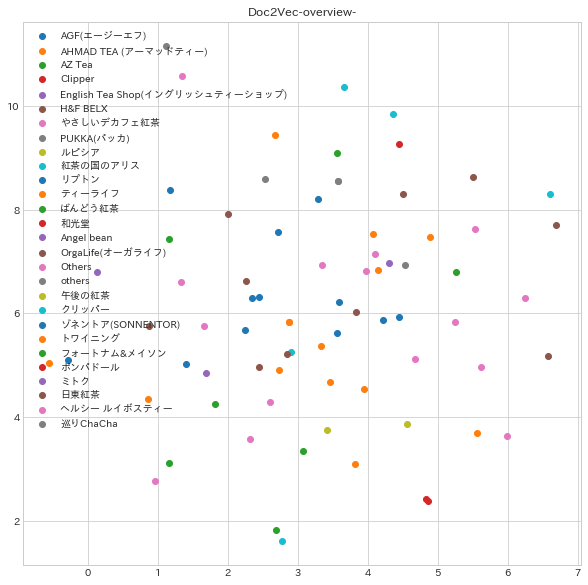

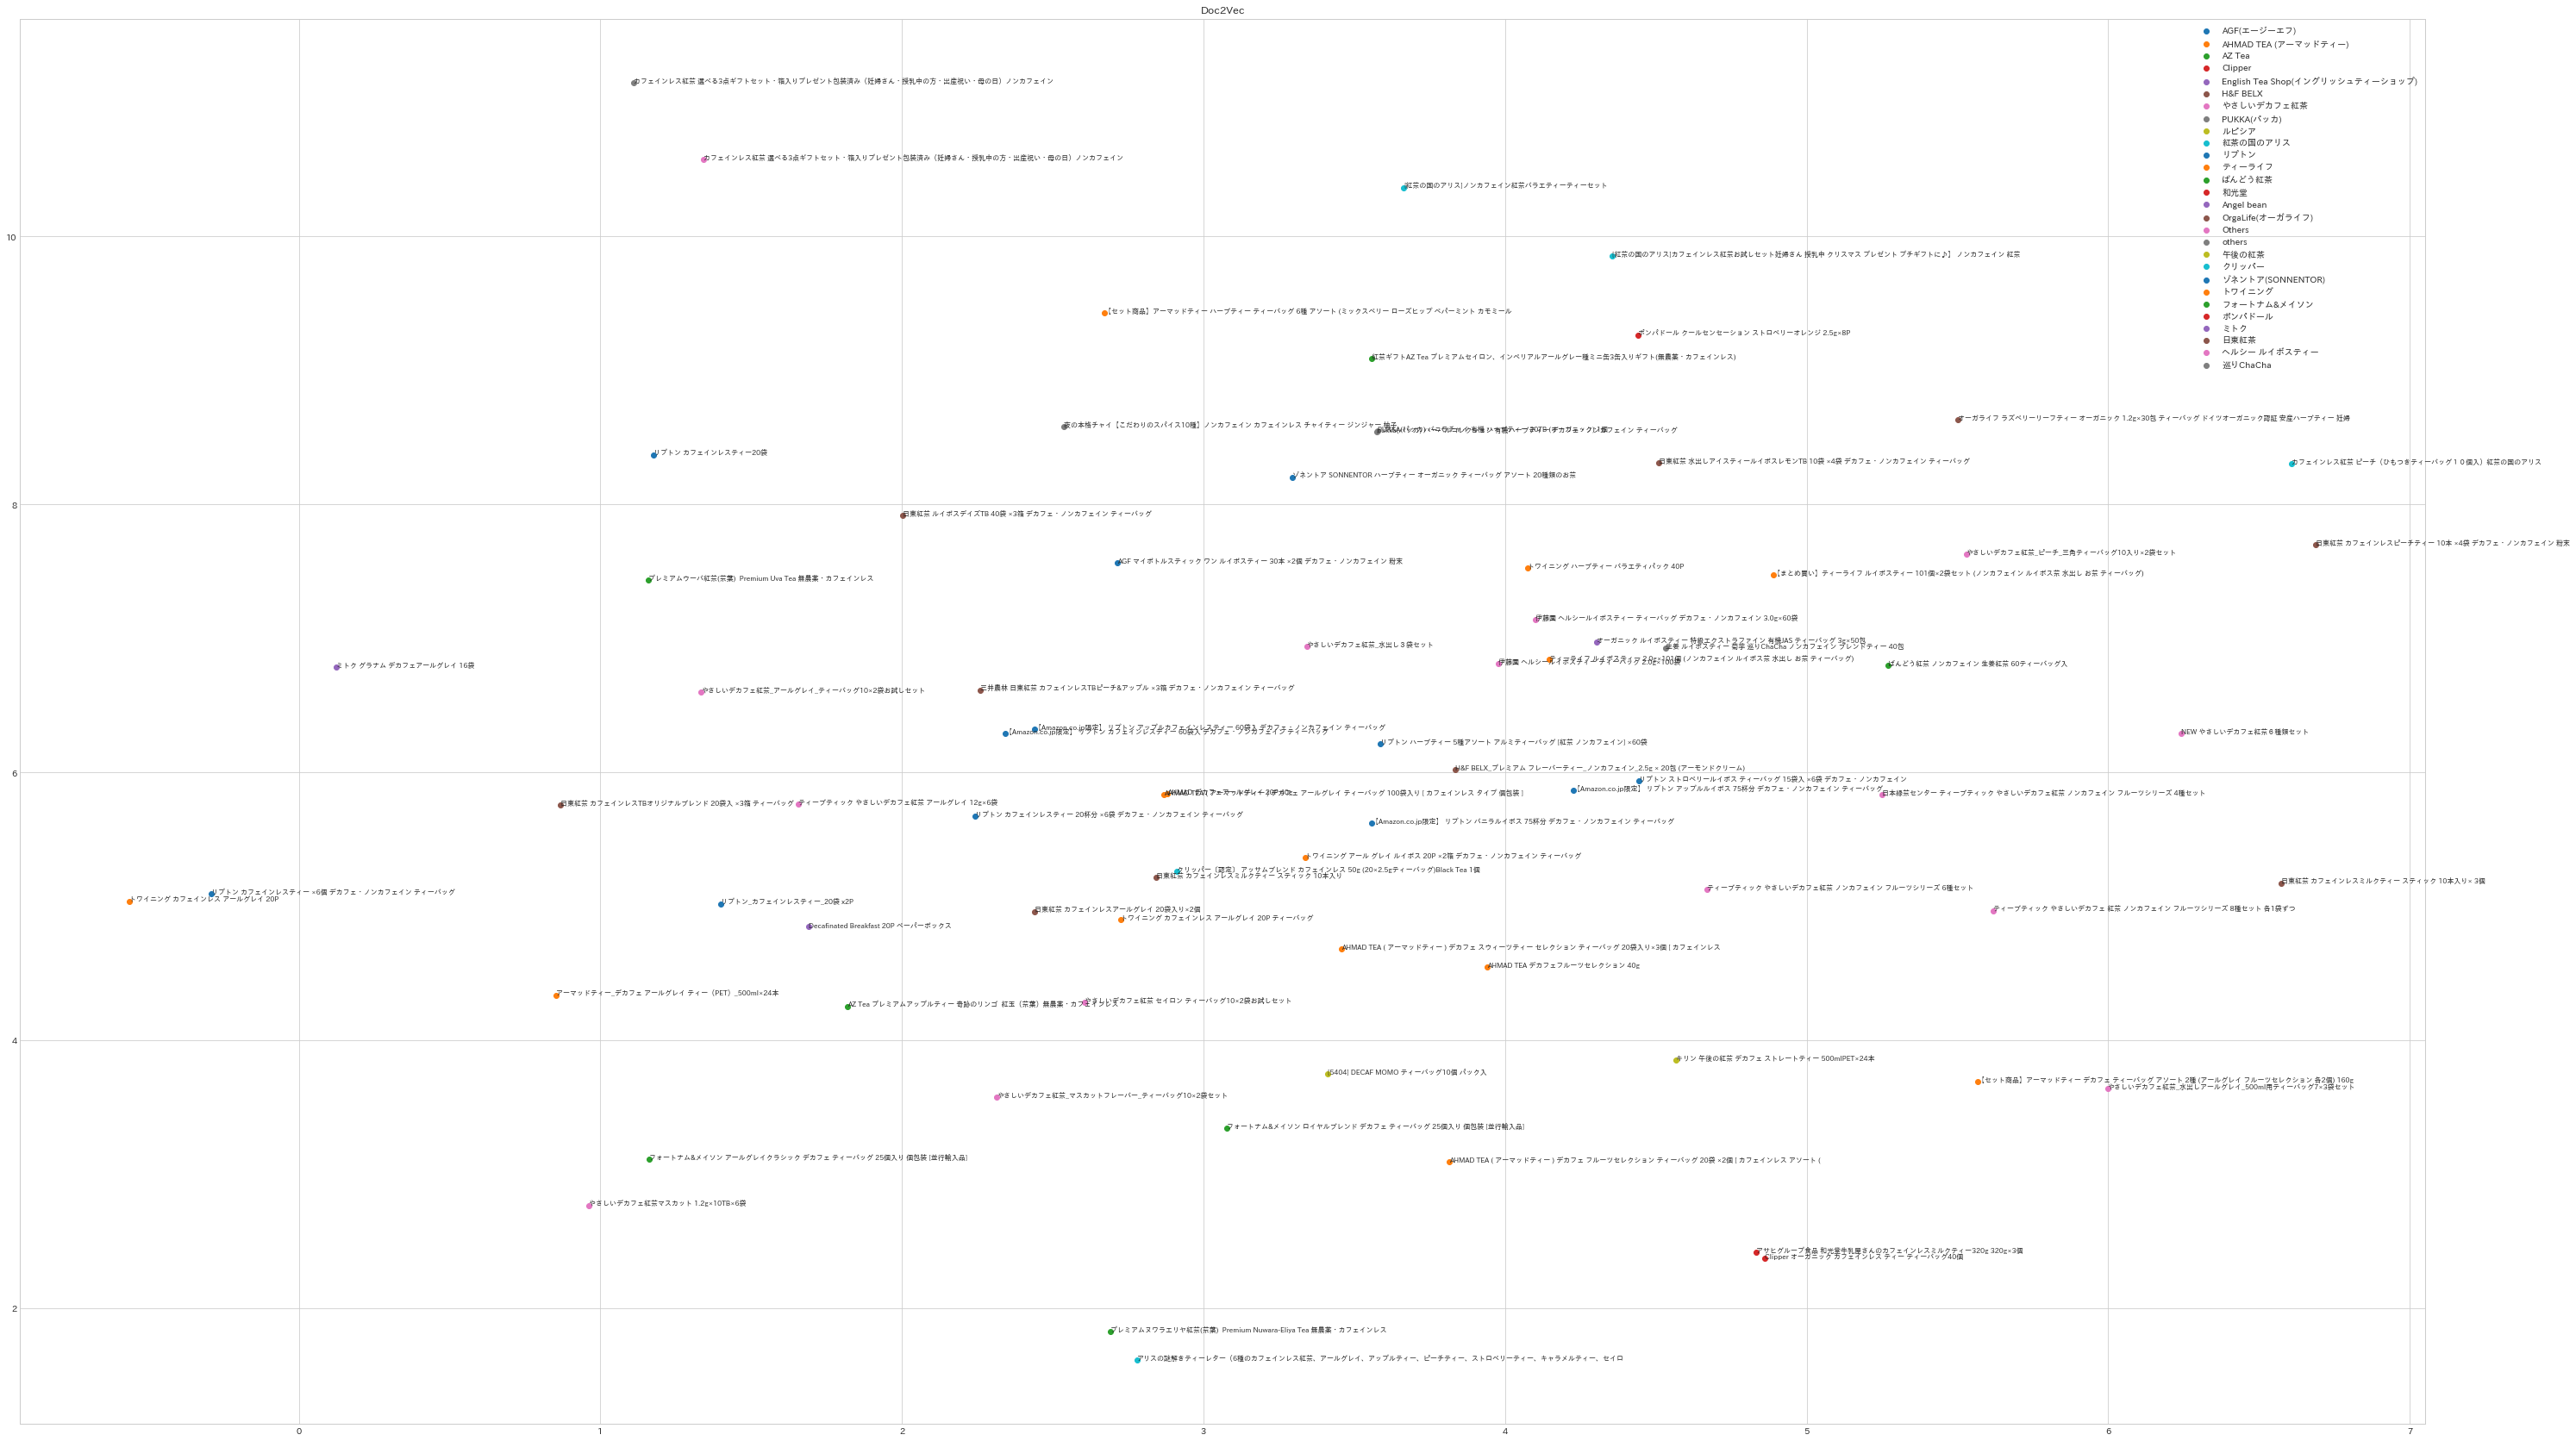

In [128]:
#Put in DataFrame
df_tsne_doc2vec = pd.DataFrame(tsne_doc2vec[:, 0],columns = ["x"])
df_tsne_doc2vec["y"] = pd.DataFrame(tsne_doc2vec[:, 1])
df_tsne_doc2vec["product_name"] = df_new_combined.product_name  
df_tsne_doc2vec["brand"] = df_new_combined.brand

pd.set_option('display.max_rows', 1000)
display(df_tsne_doc2vec.head(10))

##Visualization
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import japanize_matplotlib
plt.rcParams['font.family'] = 'IPAexGothic'

#A: Overlook
fig_overview_doc2vec = plt.figure(figsize=(10.0, 10.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

plt.legend()
plt.title("Doc2Vec-overview-")

#B: Detail
fig_detail_doc2vec = plt.figure(figsize=(50.0, 30.0))
for f in df_tsne_doc2vec['brand'].unique():
    plt.scatter(df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'x'], df_tsne_doc2vec.loc[df_tsne_doc2vec.brand == f ,'y'], label=f)

for i, txt in enumerate(df_tsne_doc2vec["product_name"].values):
    plt.annotate(txt, (df_tsne_doc2vec["x"].values[i], df_tsne_doc2vec["y"].values[i]), fontsize=8)
    
plt.legend()
plt.title("Doc2Vec")

plt.show()